# Basic CNN for traffic sign recognition
## ADL 2022

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact Stefan](mailto:sommer@di.ku.dk) if you have suggestions for improving the notebook.

The original version of the notebook was written by [Christian Igel](mailto:igel@di.ku.dk). It has been slightly modified by [Stefan Sommer](mailto:sommer@di.ku.dk) and the TAs of ADL 2022.

Do the imports first:

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
# Load the TensorBoard notebook extension
%load_ext tensorboard

Check if a GPU is available:

In [3]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


The GTSRB data wrapped in a `Dataset`:

In [4]:
class GTSRBTrafficSigns(Dataset):
  def __init__(self, root = './', url = 'https://sid.erda.dk/share_redirect/EB0rrpZwuI', filename='EB0rrpZwuI.zip', train=True, force_download=False): 
    self.img_height  = 32  
    self.img_width   = self.img_height
    self.img_height_crop = 28  
    self.img_width_crop  = self.img_height_crop

    self.train = train
    archive = os.path.join(root, filename)

    if self.train:
      self.data_folder = os.path.join(root, 'GTSRB/train')
    else:
      self.data_folder = os.path.join(root, 'GTSRB/test')

    if (not os.path.exists(self.data_folder)) or force_download:
       download_url(url, root, filename)
       extract_archive(archive, root, False)
    else:
      print('Using existing', self.data_folder)

    self.dataset_train = datasets.ImageFolder(self.data_folder)

  def __getitem__(self, index):
      image, label = self.dataset_train.__getitem__(index)
      image = transforms.Resize((self.img_width,self.img_height))(image)
      
      if self.train:
        image = transforms.RandomAffine((-5,5))(image)
        image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        if label in [11, 12, 13, 17, 18, 26, 30, 35]:
          image = transforms.RandomHorizontalFlip(p=0.5)(image)
      else:
        image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

      image = transforms.ToTensor()(image)

      return image, label

  def __len__(self):
      return self.dataset_train.__len__()

In [5]:
dataset_train = GTSRBTrafficSigns()

  0%|          | 0/290897892 [00:00<?, ?it/s]

Define the data loader for training:

In [6]:
batch_size = 128
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

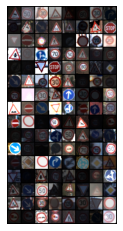

In [7]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(generator_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Let's look at some images in the batch with their label:

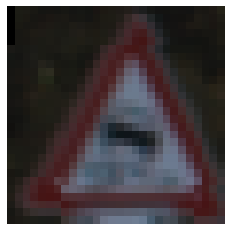

23 




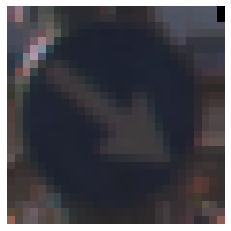

38 




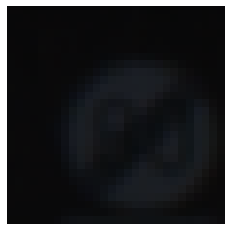

6 




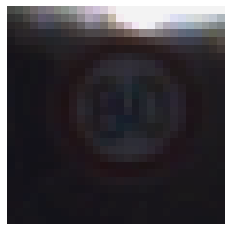

5 




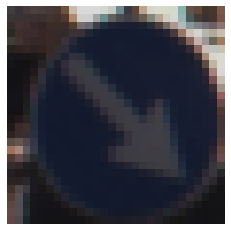

38 




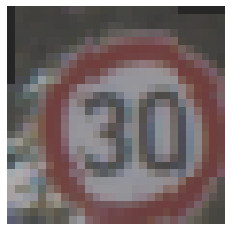

1 




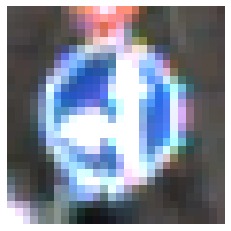

37 




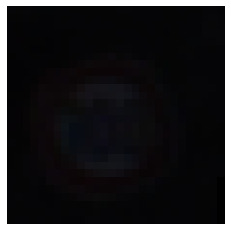

7 




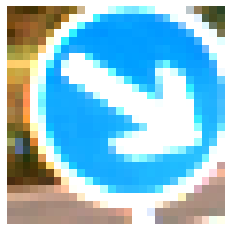

38 




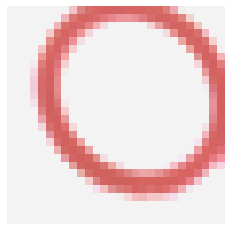

15 




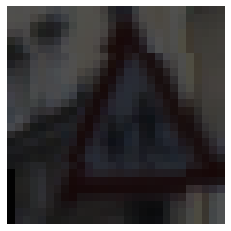

28 




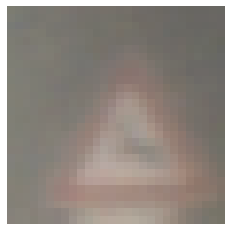

31 




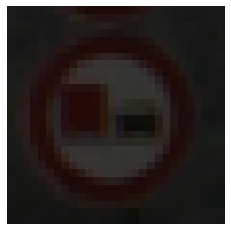

10 




In [8]:
for i in range(0,batch_size,10):
  imshow(images[i])
  print(labels[i].item(), "\n\n")


Define the neural network:

In [9]:
class Net(nn.Module):
    def __init__(self, img_size=28):
        super(Net, self).__init__()
        # Add code here .... (see e.g. 'Switch to CNN' at https://pytorch.org/tutorials/beginner/nn_tutorial.html)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=(1,1))
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=(1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=(1,1))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc3 = nn.Linear(in_features=512, out_features=43, bias=True)
        
    def forward(self, x):
        # And here ...
        x = x.view(-1, 3, 28, 28)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.elu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 512)
        x = F.elu(self.fc3(x))
        return x.view(-1, x.size(1))

Instantiate the neural network and potentially move it to GPU:

In [10]:
net = Net()
if(gpu):
  net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=512, out_features=43, bias=True)
)


Define loss and optimization algorithm:

In [11]:
criterion = nn.CrossEntropyLoss()
## switch optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)

These lines can be used to continue training:

In [12]:
cont = False
if cont:
  net.load_state_dict(torch.load('traffic_simple'))

Do the training:

In [ ]:
no_epochs = 200
for epoch in range(no_epochs):  # Loop over the dataset multiple times
    epoch_loss = running_loss = 0.0
    for i, data in enumerate(generator_train, 0):
        # Get the inputs; data is a list of [inputs, labels]
        if (gpu):
          inputs, labels = data[0].to(device), data[1].to(device)
        else:
          inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        reporting_interval = 100
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            # report_loss = running_loss / reproint
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval))
            running_loss = 0.0
    
    # Log to tensorboard
    writer.add_scalar("Loss/train", epoch_loss/(i+1.), epoch)


print('Finished Training')
writer.flush()

[1,   100] loss: 3.677
[1,   200] loss: 3.515
[1,   300] loss: 3.481
[2,   100] loss: 3.467
[2,   200] loss: 3.415


Evaluate on test set:

In [1]:
dataset_test = GTSRBTrafficSigns(train=False)
generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

correct = 0
total = 0
with torch.no_grad():
    for data in generator_test:
        if (gpu):
          images, labels = data[0].to(device), data[1].to(device)
        else:
          images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

NameError: ignored

Save network:

In [ ]:
torch.save(net.state_dict(), 'traffic_simple')

Visualize training with tensorboard

In [ ]:
%tensorboard --logdir runs